# Categorizing user complaints of the four largest telecommunications companies in South Africa using Topic Modelling

> ℹ️ Source Code

The recommended approach to running the code is to clone the git repository from https://github.com/JohnnyFoulds/dsm020-2021-oct and open it in Visual Studio Code as a [Development Container](https://code.visualstudio.com/docs/remote/create-dev-container). This will create an environment identical to what has been used during development. This notebook is located at `/workspaces/dsm020-2021-oct/coursework_02/cw.ipynb` in the development container.

The following packages were added explicitly to the development container and will be required to execute the notebook if it is to be executed outside of VS Code.

[requirements.txt](https://github.com/JohnnyFoulds/dsm020-2021-oct/blob/master/requirements.txt)

```
ipykernel==6.4.1
ipywidgets==7.6.3
nltk==3.6.5
matplotlib==3.4.3
pandas==1.3.4
openpyxl==3.0.9
pyquery==1.4.3
requests==2.26.0
scikit-learn==0.23.2
plotly==5.4.0
pycaret==2.3.6
shap==0.40.0
pyarrow==6.0.1
bs4==0.0.1
fasttext==0.9.2
kaleido==0.2.1
```

## I. Introduction

As discussed in this work’s Exploratory Data Analysis (EDA) component [1], it is possible to obtain valuable insights and potential business improvements by analysing customer reviews posted on social media sites such as Twitter, Facebook, or specifically Hellopeter in the context of this study. The Hellopeter dataset is semi-structured and contains a star rating and a net promoter score (NPS), so some trends could be observed in the  EDA report. However, the actual value lies in understanding the unstructured review text to derive actionable insights.

This study focuses exclusively on customer complaints as this is fertile ground to find possible business improvements, and, for example, monitoring customer complaint trends can aid in the early detection of emerging problems or failures in customer support. Furthermore, analysing the trends of competitors can potentially lead to opportunities for a company to set itself apart by identifying high impact focus areas. 

A key piece for understanding customer reviews is categorisation. When customer reviews can be divided into meaningful groups, they can be actioned by, for example, routing reviews to the correct workgroup to address the specific customer concerns. 

Multiple approaches can be used  for topic classification, for example, using supervised machine learning:

- A training dataset can be created with the assistance of Subject Matter Experts (SMEs) manually labelling customer complaints into categories similar to what is used in the company internal Service Request Management (SRM) system. From this data, a multi-class classification model can then be trained. However, this would be a significant undertaking as more than a hundred fault types are sometimes present in telecommunications providers’ Service Request Management (SRM) systems.
- If the ultimate goal is routing customer complaints to the correct workgroup, another alternative is to create a labelled dataset that indicates the workgroup instead of the complaint topic. Classifying by workgroup instead will require fewer labels and thus less overlap between the classes but will potentially require many reviews to be labelled before good accuracy is achieved. 

Using unsupervised learning to cluster customer complaints is desirable as it will reduce manual work and have the potential to discover topics domain experts might have missed otherwise. This study proposes using topic modelling using Latent Dirichlet Allocation (LDA) to classify topics. Unfortunately, LDA models are not turnkey technology, and it is often hard to create a model with easily interpreted topics. The primary goal of this study is to evaluate existing approaches found in the literature and present a repeatable framework and codebase that can be used for similar future categorisation projects.

Although statistical techniques exist to measure model performance, these techniques can often be misleading since a model with relatively high calculated coherence might not necessarily be easily interpretable or meet the goals of the original purpose for classifying the documents. For this reason, manual coherence reviews (by somebody with domain knowledge) is recommended instead to evaluate the model. In this study, the manual review iterations are limited to no more than one day as this will serve as a good indicator of what results can be archived with a rapid turn-around time. In practice, it is recommended that as much time as required is spent on this task since the effort will vary depending on the dataset and underlying characteristics of the documents.

After training the topic model, it will be used to label the source dataset and plot customer complaint trends. As mentioned above, there are multiple applications the categorised dataset can be used for, but this is left as future work.

Finally, in a related study [2] where the authors used topic modeling to analyse online travel reviews, they found that reviews left by unsatisfied customers have low topic separability compared to the positive reviews. However, this finding might not generalise to other datasets. Unfortunately, it is not possible to test this hypothesis on the present Hellopeter dataset as it consists of too few positive reviews to allow for a meaningful comparison. Nevertheless, observing how many iterations are required before the model produces meaningful/useful topics will give some insight into this.




In [37]:
## import libraries
import pandas as pd
import math
import datetime
import warnings
from urllib.error import HTTPError, URLError
import random
import gensim
import plotly
import json
import kaleido
from wordcloud import WordCloud
from pycaret.nlp import *
from IPython.utils import io
from IPython.display import Markdown as md
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler

> ❗ Please be sure to execute the following lines since `pycaret.nlp` requires english language model. A kernel restart is required after the models have been downloaded.

In [19]:
!python -m spacy download en_core_web_sm
!python -m textblob.download_corpora

Defaulting to user installation because normal site-packages is not writeable
  Using cached en_core_web_sm-2.3.1-py3-none-any.whl
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[nltk_data] Downloading package brown to /home/vscode/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/vscode/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /home/vscode/nltk_data...
[nltk_data]   Package conll2000 is already up-

## II. Experimental Setup

The general research framework proposed by Leung and Khalvati [3] is used in this study. Although this workflow is similar to most machine learning projects, the critical component is the manual topic coherence evaluation performed in every iteration to ensure the resulting model divides customer complaints into recognisable topics in the telecommunications industry.

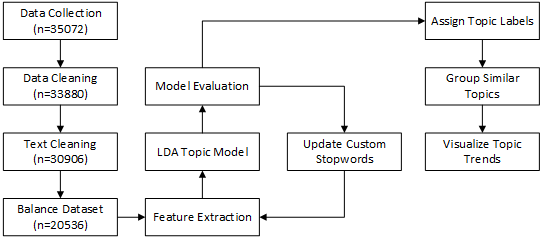

In [20]:
random_seed = 2480

### A. Data Collection and Per-Processing


The Hellopeter telecommunications dataset prepared in coursework 1 is loaded from the GitHub repository.

In [21]:
# load the raw datasets retrieved fom hellopeter
try:
    telecom_reviews = pd.read_parquet('https://github.com/JohnnyFoulds/dsm020-2021-oct/raw/master/coursework_01/data/output/telecommunications.gzip')
    telecom_reviews.info()
except HTTPError as err:
    if err.code == 4041:
        print('The file was not found on GitHub (404): %s' % err.filename)
    else:
        print('The file could not be retrieved from GitHub, please review the original error message: %s' % err.msg)
except URLError as err:
    print('There is a problem with the source URL: %s' % err.reason)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35072 entries, 0 to 35071
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          35072 non-null  object        
 1   created_at                  35072 non-null  datetime64[ns]
 2   author                      35072 non-null  object        
 3   author_id                   35072 non-null  object        
 4   review_title                35072 non-null  object        
 5   review_rating               35072 non-null  int64         
 6   review_content              35072 non-null  object        
 7   business_slug               35072 non-null  object        
 8   permalink                   35072 non-null  object        
 9   replied                     35072 non-null  bool          
 10  messages                    35072 non-null  object        
 11  industry_slug               35072 non-null  object    

#### 1) Discard the subsample of 4-5 star reviews

Since the focus of this study is on customer complaints, all compliments are removed from the dataset. However, as very few positive reviews are present in the dataset, 97% of customer reviews remain in the dataset after applying this filter.

[Text(0.5, 1.0, 'Review Star Ratings'),
 Text(0.5, 0, 'Star Rating'),
 Text(0, 0.5, 'Count')]

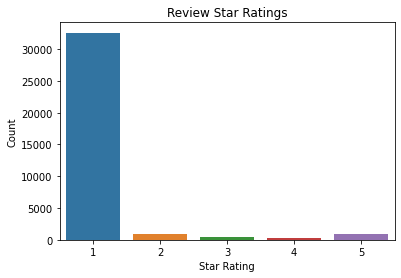

In [22]:
sns.countplot(
    data=telecom_reviews,
    x='review_rating').set(
    title='Review Star Ratings',
    xlabel='Star Rating',
    ylabel='Count')

In [23]:
def show_remaining_count(original, filtered):
    """
    Show information of data data rows remaining after filtering have been applied to the original dataset.

    Parameters
    ----------
    original : pandas.DataFrame
        The unfiltered dataset.
    filtered : pandas.DataFrame
        The filtered dataset.
    """
    count_original = original.shape[0]
    count_filtered = filtered.shape[0]

    print('(%d) reviews remaining out of (%d) -- %.2f' % (
        count_filtered,
        count_original,
        count_filtered / count_original
        ))

In [24]:
# remove the positive ratings
df_complaints = telecom_reviews[telecom_reviews.review_rating < 4].copy()

# display the records remaining
show_remaining_count(telecom_reviews, df_complaints)

(33935) reviews remaining out of (35072) -- 0.97


#### 2) Remove duplicate reviews

Duplicate customer reviews are removed by only considering the `review_content_clean` column. Other columns are ignored since reviews could have been posted one after another resulting in, for example, different timestamps. 

In [25]:
df_complaints.drop_duplicates(subset=['review_content_clean'], keep='first', inplace=True)

# display the records remaining
show_remaining_count(telecom_reviews, df_complaints)

(33880) reviews remaining out of (35072) -- 0.97


#### 3) Remove reviews shorter than 200 characters

In a study [4] to understand the limiting factors of topic modeling, the researchers found that the length of documents plays a crucial role. Since the Hellopeter dataset has a sufficiently large number of documents (customer complaints), reviews with fewer than 200 characters are removed.

In [26]:
min_length = 200
df_complaints['review_length'] = df_complaints.review_content_clean.str.len()
df_complaints = df_complaints[df_complaints.review_length >= min_length]

# display the records remaining
show_remaining_count(telecom_reviews, df_complaints)

(30906) reviews remaining out of (35072) -- 0.88


#### 4) Removing special characters

Although the library used for topic modeling removes special characters from the document text before training the model, this step removes newline characters and repeated spaces to improve the readability when displaying document samples for coherence evaluation.

In [28]:
def remove_special_characters(text_series:pd.Series) -> pd.Series:
    """
    Remove special characters from a text series.

    Parameters
    ----------
    text_series : pandas.Series
        The text series to clean.

    Returns
    -------
    pandas.Series
        The cleaned text series.
    """
    text_series = text_series.str.replace(r'[\n\xa0]+', ' ', regex=True)
    text_series = text_series.str.replace(r'^\s+', '', regex=True)  
    text_series = text_series.str.replace(r'$\s+', '', regex=True)  
    text_series = text_series.str.replace(r'\s+', ' ', regex=True)    

    return text_series

df_complaints['review_content_clean'] = remove_special_characters(df_complaints['review_content'])

#### 5) Create a balanced data set 

Random undersampling is used to create a dataset where an equal number of customer complaints represents each telecommunications company. Creating a balanced dataset prevents bias towards the companies receiving more reviews to allow for a fair comparison of trends.

After performing this step, 20,536 documents remain. This number of documents is significantly larger than the relevant studies examined in the literature review whilst still small enough to be locally processed by a modern mid-range workstation. 

[Text(0.5, 1.0, 'Reviews per Company'),
 Text(0.5, 0, 'Business'),
 Text(0, 0.5, 'Count')]

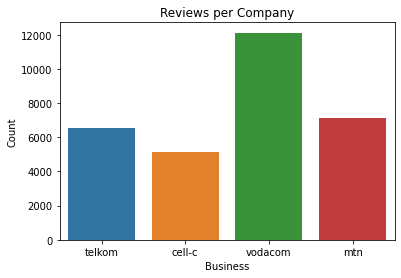

In [29]:
sns.countplot(
    data=df_complaints,
    x='business_slug').set(
    title='Reviews per Company',
    xlabel='Business',
    ylabel='Count')

In [30]:
# perform random under sampling
under_sampler = RandomUnderSampler(random_state=random_seed)
df_complaints_balance, _ = under_sampler.fit_resample(df_complaints, df_complaints.business_slug)

# display the records remaining
show_remaining_count(df_complaints, df_complaints_balance)

(20536) reviews remaining out of (30906) -- 0.66


[Text(0.5, 1.0, 'Reviews after filtering'),
 Text(0.5, 0, 'Business'),
 Text(0, 0.5, 'Count')]

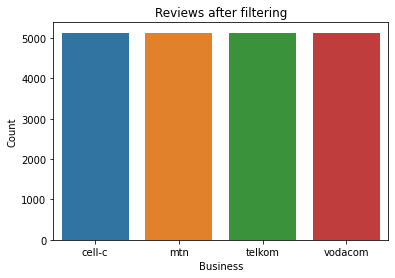

In [31]:
sns.countplot(
    data=df_complaints_balance,
    x='business_slug').set(
    title='Reviews after filtering',
    xlabel='Business',
    ylabel='Count')

### B. Technical Implementation

The Pycaret low-code machine learning library is used for creating the LDA topic model. Pycaret utilises standard libraries like spaCy, scikit-learn, and Gemsin, and the full implementation details are available as an open-source project. The choice to use this “wrapper” library was to eliminate the typical “boilerplate”  code used in NLP projects and focus on the model and outcomes rather than on implementation details.

The class below abstracts this library even further to provide functionality specific functionality required for this study and serve as a re-usable component for similar future data science projects.

In [41]:
class TopicModeling():
    """
    Class to perform topic modeling on the reviews.
    """
    def __init__(self, data:pd.DataFrame, random_seed:int=None):
        """
        Initialize the class.

        Parameters
        ----------
        data : pandas.DataFrame
            The dataframe containing the reviews.
        random_seed : int
            The random seed to use.
        """
        # set the data
        assert isinstance(data, pd.DataFrame), 'data must be a pandas.DataFrame'
        self.data = data
        self.data.reset_index(inplace=True, drop=True)
        self.assigned_data = None
        self.text = None

        # set the random seed
        if random_seed is None:
            self.random_seed = random.randint(150, 9000)
        else:
            self.random_seed = random_seed

    def setup(self, target:str=None, custom_stopwords:list=None, verbose:bool=True) -> dict:
        """
        Perform the pre-prossesing steps with the aid of the PyCaret library.
        
        The following actions are performed:
            1. Removing numeric characters from the text.
            2. Removing special characters.
            3. Word Tokenization
            4. Remove the English stopwords as defined in the NLTK library.
            5. Bigram Extraction.
            6. Trigram Extraction.
            7. Perform Lemmatization using the spaCy library. The following parts of speech are retained: `["NOUN", "ADJ", "VERB", "ADV"]`
            8. Remove custom stopwords        

        Parameters
        ----------
        target : str
            The target variable.
        custom_stopwords : list
            A list of custom stopwords to use.
        verbose : bool
            Whether to display the pre-processing steps.

        Returns
        -------
        result : dict
            Return a dictionary containing the text, corpus, and id2word data.
        """
        result = {}

        # set the target variable
        self.target = target

        # set the custom stopwords
        if custom_stopwords is not None:
            self.custom_stopwords = custom_stopwords
        else:
            self.custom_stopwords = []

        # set the verbose flag
        self.verbose = verbose

        # pre-process the data
        result['text'], _, result['corpus'], result['id2word'], *_ = setup(
            data=self.data, 
            target=target, 
            verbose=verbose,
            custom_stopwords=self.custom_stopwords,
            session_id=self.random_seed)

        self.text = result['text']
        self.corpus = result['corpus']
        self.id2word = result['id2word']
        
        # reset the assigned data
        self.assigned_data = None

        return result

    def create_model(self, model:str='lda', num_topics:int=4, verbose:bool=False):
        """
        Train the given topic model specified by the 'model' parameter.

        Parameters
        ----------
        model : str, default 'lda'
            Models available (ID - Name):

            * 'lda' - Latent Dirichlet Allocation         
            * 'lsi' - Latent Semantic Indexing           
            * 'hdp' - Hierarchical Dirichlet Process
            * 'rp' - Random Projections
            * 'nmf' - Non-Negative Matrix Factorization

        num_topics : int, default 4
            The number of topics to use.
        verbose : bool, default False
            When set to True, status updates are displayed.

        Returns
        -------
        Trained Model
        """
        # check for allowed models
        assert model in ['lda', 'lsi', 'hdp', 'rp', 'nmf'], 'model must be one of the following: lda, lsi, hdp, rp, nmf'

        # create the model
        self.trained_model = create_model(
            model=model, 
            num_topics=num_topics, 
            verbose=verbose, 
            multi_core=True)

        # reset the assigned data
        self.assigned_data = None

        return self.trained_model

    def create_tuned_model(self, model:str='lda', fold:int=10, verbose:bool=True):
        """
        Train the given topic model specified by the 'model' parameter.

        Parameters
        ----------
        model : str, default 'lda'
            Available models (ID - Model):

            * 'lda' - Latent Dirichlet Allocation         
            * 'lsi' - Latent Semantic Indexing           
            * 'hdp' - Hierarchical Dirichlet Process
            * 'rp' - Random Projections
            * 'nmf' - Non-Negative Matrix Factorization

        fold : int, default 10
            The number of folds to use. Must be at least 2. 
        verbose : bool, default True
            When set to True, status updates are displayed.

        Returns
        -------
        Trained Model with optimized ``num_topics`` parameter.
        """
        # check for allowed models
        assert model in ['lda', 'lsi', 'hdp', 'rp', 'nmf'], 'model must be one of the following: lda, lsi, hdp, rp, nmf'

        # create the tuned model
        self.trained_model = tune_model(
            model=model, 
            fold=fold, 
            verbose=verbose, 
            multi_core=True)

        # reset the assigned data
        self.assigned_data = None

        return self.trained_model

    def assign_model(self, verbose:bool=False) -> pd.DataFrame:
        """
        Assigns topic labels to the dataset using the trained_model.

        Parameters
        ----------
        verbose : bool, default False
            When set to True, status updates are displayed.

        Returns
        -------
        pandas.DataFrame containing the topic labels.
        """
        # assign the topic labels
        df_assigned = assign_model(self.trained_model, verbose=verbose)
        self.assigned_data = self.data.join(df_assigned.iloc[:,-(2+self.trained_model.num_topics):])
        
        # join the cleaned topic text
        if self.text is not None:
            self.assigned_data = self.assigned_data.join(
                pd.DataFrame([" ".join(item) for item in self.text], columns=['Topic_text'])
            )
        else:
            warnings.warn('The Topic_text column could not be populated, please ensure that the model has been trained.')
            

        return self.assigned_data

    def extract_topic_coherence_data(self, num_words:int=10, num_sample:int=3, verbose:bool=False) -> list:
        """
        Extracts topic coherence data from the assigned data for manual review.

        Parameters
        ----------
        num_words : int, default 10
            The number of words to use for each topic.

        num_sample : int, default 3
            The number of samples itemf from the target to include for each topic.

        verbose : bool, default False
            When set to True, status updates are displayed.

        Returns
        -------
        list containing the topic coherence data.
        """
        assert self.trained_model is not None, 'The model must be trained before coherence data can be extracted.'

        output = []

        # get the assigned data
        if self.assigned_data is None:
            self.assigned_data = self.assign_model(verbose=verbose)

        for topic_num, word_data in self.trained_model.show_topics(formatted=False, num_words=10, num_topics=self.trained_model.num_topics):
            topic = {'topic_num': topic_num}
            output.append(topic)
            
            # get the most siginficant words for the topic
            topic['word_list'] = " ".join([word for word, _ in word_data])

            # get the list of sample items for the topic
            filtered_df = self.assigned_data.loc[self.assigned_data["Dominant_Topic"] == 'Topic %d' % topic_num]
            topic['samle_list'] = filtered_df.sort_values(by='Perc_Dominant_Topic', ascending=False).head(num_sample)[self.target].tolist()
                  
        # sort the data by topic number
        output = sorted(output, key=lambda k: k['topic_num'])

        return output


    def show_topic_coherence_data(self, num_words:int=10, num_sample:int=3, max_length:int=300, verbose:bool=False):
        """
        Displays the topic coherence data.

        Parameters
        ----------
        num_words : int, default 10
            The number of words to use for each topic.

        num_sample : int, default 3
            The number of samples itemf from the target to include for each topic.

        max_length : int, default 250
            The maximum length of the topic text to display.

        verbose : bool, default False
            When set to True, status updates are displayed.
        """
        output = []

        # extract the topic coherence data
        topic_coherence_data = self.extract_topic_coherence_data(num_words=num_words, num_sample=num_sample, verbose=verbose)
    
        output.append('<table>')

        # format the table header
        output.append('<tr>')
        str_header = '<th>Topic</th><th>Tokens</th>'
        for i in range(num_sample):
            str_header += '<th>Sample %d</th>' % (i+1)
        output.append(str_header)
        output.append('</tr>')

        # format each topic
        for topic in topic_coherence_data:
            output.append('<tr style="vertical-align:top">')
            str_row = '<td>%d</td><td>%s</td>' % (topic['topic_num'], topic['word_list'])
            for sample in topic['samle_list']:
                str_row += '<td>%s</td>' % sample[:max_length]
            output.append(str_row)
            output.append('</tr>')

        output.append('</table>')

        # display the output as markdown
        display(HTML('\n'.join(output)))

    def plot_topic_distribution(self, interactive:bool=True):
        """
        Plot the Topic Infer Distribution.

        Parameters
        ----------
        interactive : bool, default True
            When set to True, the plot is displayed in an interactive window.
        """
        assert self.trained_model is not None, 'The model must be trained before plotting the topic distribution.'

        if interactive:
            plot_model(self.trained_model, plot='topic_distribution')
        else:
            with io.capture_output() as captured_plot:
                plot_model(self.trained_model, plot='topic_distribution')
    
            json_plotly = json.dumps(list(captured_plot.outputs[1].data.items())[0][1])
            figure_plotly = plotly.io.from_json(json_plotly)
            figure_plotly.show(renderer="png")

    def plot_wordcloud(self, topic_num:int, plot:bool=True) -> WordCloud:
        """
        Plot the Topic Wordcloud.

        Parameters
        ----------
        topic_num : int
            The topic number to plot.

        plot : bool, default True
            When set to True, the plot is rendered.

        Returns
        -------
        wordcloud : WordCloud
            The wordcloud object that can be used to generate the plot.
        """
        assert self.trained_model is not None, 'The model must be trained before plotting the topic wordcloud.'
        assert topic_num < self.trained_model.num_topics, 'The topic number (zero based) must must not exceed the number of topics in the model.'

        # get the assigned data
        if self.assigned_data is None:
            self.assigned_data = self.assign_model(verbose=False)

        # filter the dataset for the selected topic
        filtered_df = self.assigned_data.loc[self.assigned_data["Dominant_Topic"] == 'Topic %d' % topic_num]

        # if mo documents match the topic, return None
        if (filtered_df.shape[0] == 0):
            print('No data found for topic %d' % topic_num)
            return None

        # get the text for each row in the dataset
        topic_text = " ".join(review for review in filtered_df['Topic_text'])

        # fit the wordcloud
        wordcloud = WordCloud(
            width=800,
            height=800,
            background_color="white",
            min_font_size=10,
        ).generate(topic_text)

        # plot the wordcloud
        if (plot):
            plt.figure(figsize=(8, 8), facecolor=None)
            plt.imshow(wordcloud)
            plt.axis("off")
            plt.tight_layout(pad=0)

        return wordcloud

    def plot_wordcloud_grid(self, figsize:tuple=(8, 8)):
        """
        Plot the Topic Wordclouds in a grid.

        Parameters
        ----------
        figsize : tuple, default (8, 8)
            The figure size.
        """
        assert self.trained_model is not None, 'The model must be trained before plotting the topic wordcloud.'

        fig = plt.figure(figsize=figsize, facecolor=None)
        for i in range(self.trained_model.num_topics):
            # get the current topic word cloud
            wordcloud = self.plot_wordcloud(topic_num=i, plot=False)

            ax = fig.add_subplot(math.ceil(self.trained_model.num_topics / 3.0),3,i+1)

            if wordcloud is not None:
                ax.imshow(wordcloud)

            ax.set_title('Topic %d' % i)
            ax.axis('off')

#### 1) Unit Tests

The code in this section tests the main functionality of the topic modelling class. The goal was not to achieve complete code coverage as it is, for example, hard to measure the correctness of plots. Instead, this test class serves as a starting point for future enhancements using a test-driven development approach.

In [33]:
import unittest

class ToplicModelingTestSet(unittest.TestCase):
    """
    Unit testing for the custom topic modeling class implemented to classify 
    telecommunications complaints.
    """

    def setUp(self):
        """
        Set up the test set.
        """
        self.sample_size = 100
        self.random_seed = 2000
        self.data = df_complaints_balance.sample(n=self.sample_size, random_state=self.random_seed)
        self.target = 'review_content_clean'
        self.model = 'lda'
        self.num_topics = 6
        self.fold = 2

    def test_class_exist(self):
        """
        Test if the class exists.
        """
        self.assertIsNotNone(TopicModeling)

    def test_class_init(self):
        """
        Test if the class can be initialized.
        """
        topic_modeler = TopicModeling(self.data, self.random_seed)
        self.assertIsNotNone(topic_modeler)
        self.assertEqual(topic_modeler.data.shape[0], self.data.shape[0])

    def test_class_setup(self):
        """
        Test the text pre-processing steps.
        """
        topic_modeler = TopicModeling(self.data, self.random_seed)
        result = topic_modeler.setup(target=self.target, custom_stopwords=None, verbose=False)
        self.assertEqual(len(result['text']), self.data.shape[0])
        self.assertIsNotNone(result['corpus'])
        self.assertIsNotNone(result['id2word'])

    def test_class_create_model(self):
        """
        Test the model creation.
        """
        # create the topic modeler and perform the pre-processing steps
        topic_modeler = TopicModeling(self.data, self.random_seed)
        topic_modeler.setup(target=self.target, custom_stopwords=None, verbose=False)

        # create the model
        model = topic_modeler.create_model(model=self.model, num_topics=self.num_topics, verbose=False)
        self.assertIsNotNone(model)
        self.assertIsInstance(model, gensim.models.ldamulticore.LdaMulticore)
        self.assertEqual(len(model.get_topics()), self.num_topics)

    def test_class_create_tuned_model(self):
        """
        Test the model creation with optimized parameters.
        """
        # create the topic modeler and perform the pre-processing steps
        topic_modeler = TopicModeling(self.data, self.random_seed)
        topic_modeler.setup(target=self.target, custom_stopwords=None, verbose=False)

        # create the model
        model = topic_modeler.create_tuned_model(model=self.model, fold=self.fold, verbose=False)
        self.assertIsNotNone(model)
        self.assertIsInstance(model, gensim.models.ldamulticore.LdaMulticore)

    def test_class_plot_topic_distribution(self):
        """
        Test the topic distribution plot.
        """
        # create the topic modeler and perform the pre-processing steps
        topic_modeler = TopicModeling(self.data, self.random_seed)
        topic_modeler.setup(target=self.target, custom_stopwords=None, verbose=False)

        # create the model
        model = topic_modeler.create_model(model=self.model, num_topics=self.num_topics, verbose=False)

        # plot the topic distribution
        with io.capture_output() as captured:
            topic_modeler.plot_topic_distribution(interactive=False)

        # the cell output should be a png image
        self.assertEqual(list(captured.outputs[0].data.items())[0][0], 'image/png')

    def test_class_plot_wordcloud(self):
        """
        Test the topic wordcloud plot.
        """
        # create the topic modeler and perform the pre-processing steps
        topic_modeler = TopicModeling(self.data, self.random_seed)
        topic_modeler.setup(target=self.target, custom_stopwords=None, verbose=False)

        # create the model
        model = topic_modeler.create_model(model=self.model, num_topics=self.num_topics, verbose=False)

        # get the topic wordcloud
        output = topic_modeler.plot_wordcloud(1, plot=False)
        self.assertIsInstance(output, WordCloud)

    def test_class_extract_topic_coherence_data(self):
        """
        Test the extraction of topic coherence data.
        """
        # create the topic modeler and perform the pre-processing steps
        topic_modeler = TopicModeling(self.data, self.random_seed)
        topic_modeler.setup(target=self.target, custom_stopwords=None, verbose=False)

        # create the model
        model = topic_modeler.create_model(model=self.model, num_topics=self.num_topics, verbose=False)

        # extract the topic coherence data
        output = topic_modeler.extract_topic_coherence_data(num_words=10, num_sample=3, verbose=False)
        self.assertEqual([document['topic_num'] for document in output], list(range(self.num_topics)))

# execute the topic modeling tests
unittest.main(argv=['ignored', '-v'], exit=False)
#unittest.main(argv=['ignored', '-v', 'ToplicModelingTestSet.test_class_extract_topic_coherence_data'], exit=False)

test_class_create_model (__main__.ToplicModelingTestSet)
Test the model creation. ... [nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
ok
test_class_create_tuned_model (__main__.ToplicModelingTestSet)
Test the model creation with optimized parameters. ... [nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


ok
test_class_exist (__main__.ToplicModelingTestSet)
Test if the class exists. ... ok
test_class_extract_topic_coherence_data (__main__.ToplicModelingTestSet)
Test the extraction of topic coherence data. ... 

Best Model: Latent Dirichlet Allocation | # Topics: 400 | Coherence: 0.7413


[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
ok
test_class_init (__main__.ToplicModelingTestSet)
Test if the class can be initialized. ... ok
test_class_plot_topic_distribution (__main__.ToplicModelingTestSet)
Test the topic distribution plot. ... [nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
ok
test_class_plot_wordcloud (__main__.ToplicModelingTestSet)
Test the topic wordcloud plot. ... [nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
ok
test_class_setup (__main__.ToplicModelingTestSet)
Test the text pre-processing steps. ... [nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
ok

----------------------------------------------------------------------
Ran 8 tests in 104.816s

OK


## III. Topic Modeling

In [34]:
# set the colors per provider
palette = sns.color_palette('tab10')

# set the plot style
sns.set_theme(style="whitegrid")
sns.set(rc={"figure.figsize":(15, 8)})
sns.set_palette(palette)

### A)	Determining the number of topics

In experiments [4] where the number of documents, the length of documents, and the number of topics (K) are varied, the results show that it is essential to pick a K value that is not larger than the number of underlying topics in the dataset as it will result in overfitting. Therefore, as a starting point o prevent a situation where the model produces topics that cannot be easily distinguished, the following code is used to vary the K value and find the point where the calculated topic coherence is the highest.

```python
# create a sample dataset for testing
df_train = df_complaints_balance

# create the topic modeler and perform the pre-processing steps
topic_modeler = TopicModeling(df_train, random_seed)
topic_modeler.setup(target='review_content_clean', custom_stopwords=None, verbose=True)
topic_modeler.create_tuned_model(model='lda', verbose=True)
```

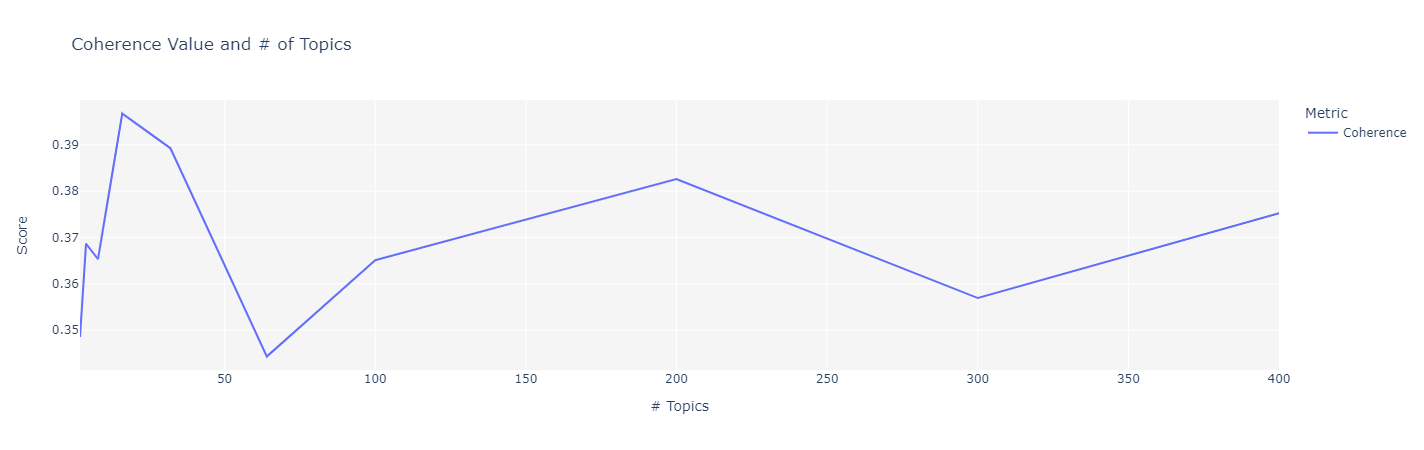

> Best Model: Latent Dirichlet Allocation | # Topics: 16 | Coherence: 0.3967

```
LdaModel(num_terms=16731, num_topics=16, decay=0.5, chunksize=100)
```

### B. Model Training and Evaluation

The steps and code in this section are repeated until a suitable model is found. Initially, no custom stopwords are used to establish a baseline. This, however, does not mean that the first model does not remove the most common stopwords since the standard list of words from the NLTK library is removed at every iteration. The custom stopwords and number of topics parameters are fine-tuned at every iteration to arrive at the desired model. Small incremental changes should as adding just one custom stopword could drastically alter the topics found.


> ℹ️ The comments below shows the iterative steps, but the specific topics mentioned will not nessacarily be exactky the same when this experiment is replicated. The same outcome should however be reached through the process of manual topic coherence evaluation.

In [19]:
# custom stopwords
custom_stopwords = [
    'vodacom', 'mtn', 'telkom', # 1) remove business names
    'phone', # 3) Topic 7 is too generic clustering different logical topics together
    'cell', # 4) Topic 0 has very view reviews and 'cell' is too generic and might be confused with the `cell c` business name
    'month', # 5) For Topic 11, month is not a meaningful word to indicate what the logical topic is about.
    'day', # 7) Topic 11 this is used in is perhaps useful to say that it is complaints about delayed responsed, but exluding it for the same reason as month. 
    'call', # 8) A large number of documents are under topic 11 and this is a very generic word. It should be noted though that step (7) made the topics to be of a worst quality.
    'tell', 'speak', 'say', # 9) Topic 14 is large, but the main tokens are very generic. NOTE: At step 9 the topics do look usable.
]

# number of topics
# num_topics=16 # 1)
# num_topics=14 # 2) when using 16 topics, topic 11 & 12 had only one document after assignment
num_topics=16 # 6) Experiment with using 16 topics after adding addtional stopwords

# create a sample dataset for testing
df_train = df_complaints_balance

# create the topic modeler and perform the pre-processing steps
topic_modeler = TopicModeling(df_train, random_seed)
topic_modeler.setup(
    target='review_content_clean', 
    custom_stopwords=custom_stopwords, 
    verbose=True)

topic_modeler.create_model(
    model='lda', 
    num_topics=num_topics, 
    verbose=True)

#### 1) Topic Distribution

The document distribution plot is helpful to identify situations where most of the documents are clustering around one or two topics since this could indicate that those particular topics are too general. The model might be improved by adding one or more of the topic tokens to the custom stopwords list.

The distribution plot should also be read while reviewing the coherence evaluation data as some of the topics might seem like they perfectly meet the project goals but are too sparsely populated with documents clustering around more general topics instead.

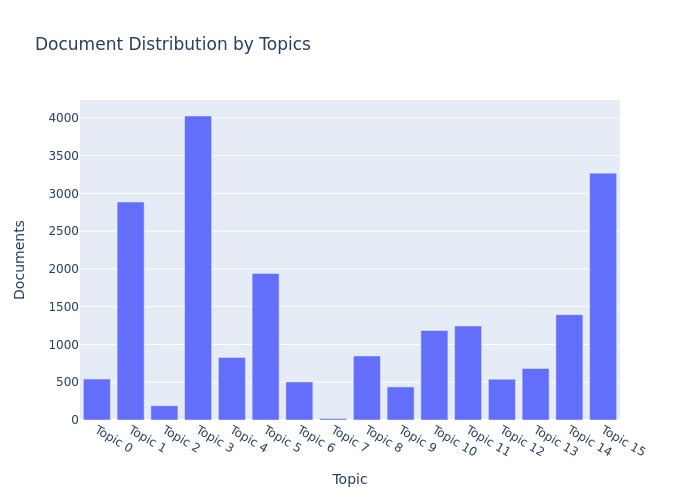

In [20]:
topic_modeler.plot_topic_distribution(interactive=False)

#### 2) Wordcloud

A word cloud is created from all the documents in a topic. This view shows only the words considered as input for the LDA model with standard- and custom stopwords are not. This plot is useful as it provides an overview of what documents assigned to a topic look like.

> ℹ️ In some of the iterations, no documents were assigned to one or more topics. When this occurs, only the topic label is displayed to allow evaluation of the other topics.

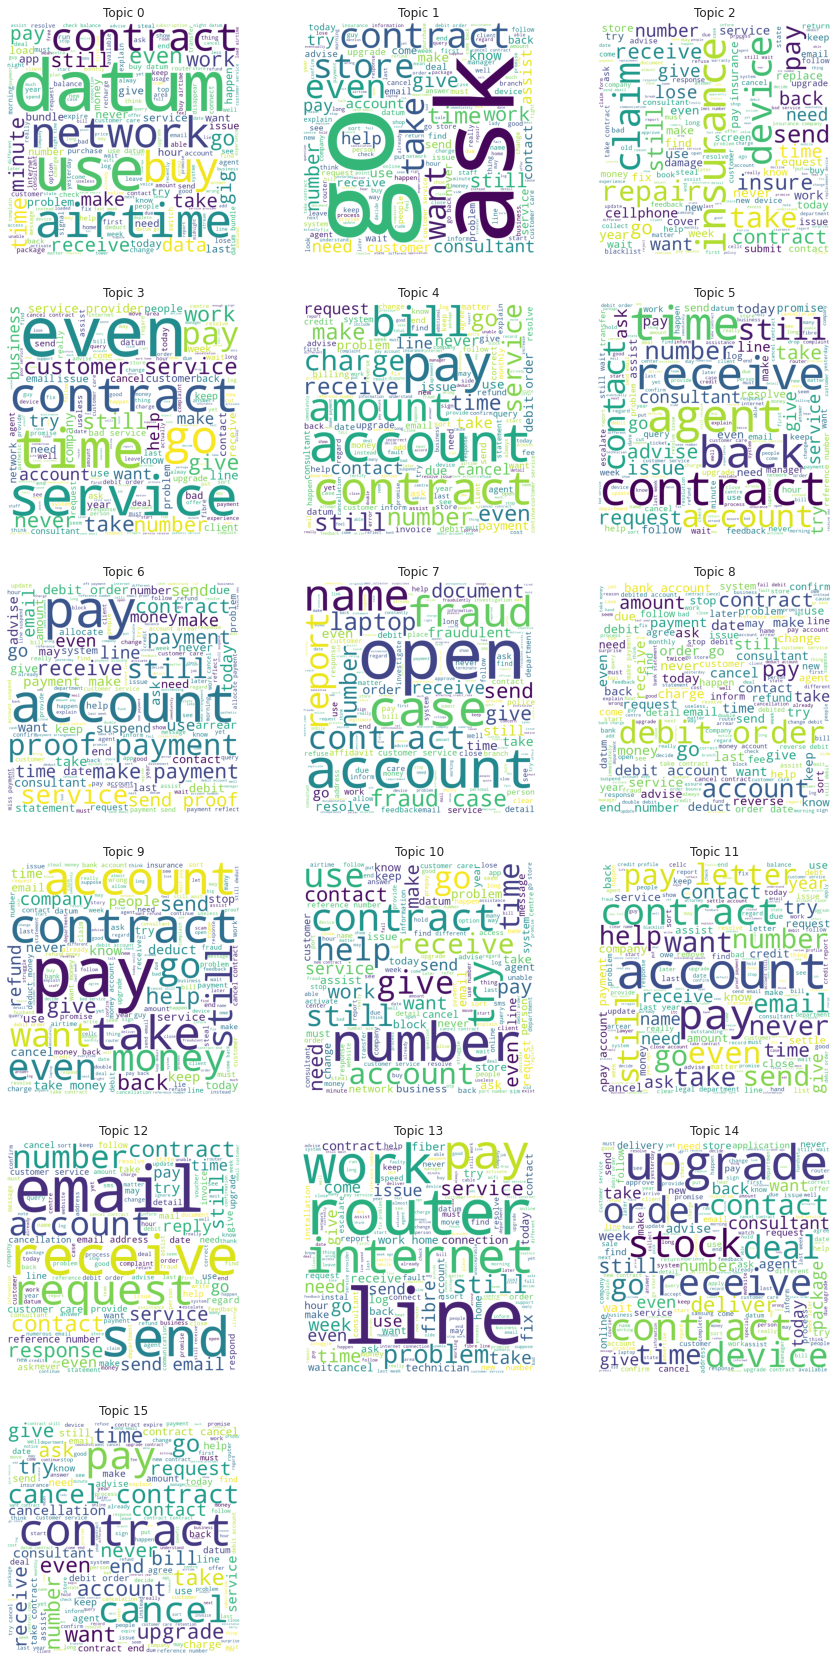

In [21]:
topic_modeler.plot_wordcloud_grid(figsize=(15, 30))

#### 3) Coherence Evaluation Data

When evaluating the quality (coherence) of topics, the coherence evaluation data should be the primary focus, used in conjunction with the topic distribution plot mentioned above. For every topic, a list of the top tokens that were used to establish the topic is shown together with a sample of documents most closely associated with the topic. When fine-tuning the model, words from the tokens are selected one at a time for the next iteration to add as a stopword. If adding the stopword worsens the new model, it can be removed again, and another word tried instead. 

The code section below has been annotated with numbers and comments to show what was done at every iteration. When using this approach in practice, it is recommended that similar annotations are used to allow for easy rollback when a change negatively affects the results.

By examining sample documents together with the topic tokens, an evaluation can be made whether or not documents are grouped similarly to what a human reviewer might have done. This evaluation is also essential when annotating topics with meaningful labels.

In [34]:
topic_modeler.show_topic_coherence_data(num_sample=4, max_length=400)

Topic,Tokens,Sample 1,Sample 2,Sample 3,Sample 4
0,datum use airtime buy network data minute app gig bundle,I Buy data bundle and it dissapears. With under an hour more than 1gig gets used up while im sleeping. I cant even use that much while on the internet in such n short time. Buy voice bundles and when I try to call ot says I dont have airtime but have bundle min left,"Imagine I had R100 airtime. Buy a one gig bundle but my out of bundle settings are on unlimited and it used the R80 before it ate the blady thing designed to run it which is data...... I want my R80 back. **** you'll and the way you guys do business To think I used to work for cell c , what a ****en disgrace.",The Vodacom app advertises that if you buy a Just For You data bundle on the app you will receive 35 vodabucks. It usually works. The last 7 or 8 times it has not given me the 35 vodabucks. I only buy the data bundles for the vodabucks as I have wifi.,"I recharge with R700 and received R700 free airtime and I was able to use it for calls. However when I purchased free bundles which included 500 minutes to all networks, all of the sudden my free airtime is locked and only my minutes are being used. I feel like this is a rip off, this free airtime will expire soon and it should be the one used first before my minutes. Telkom should do something ab"
1,go store back ask take consultant help would get need,"I visited the Mtn store in Mall @ Carinival. I had some questions around the 1000GB Sim-only deal. This is a ""STORE ONLY"" Deal, hence why I went in to the store. The Mtn consultant could not answer my questions and told met to phone the customer service number in the Mtn Deals booklet. I was sent from the one consultant to the other... Eventually I spoke to someone telling me that they cannot help",Good day I would like that telkom to look into that we as customers can do sim swaps over the phone without going to the Telkom store because I think It would be really helpful and easy to do it just from home.,Amidst people dying - MTN still insists that one HAS to physically go into one of their stores to do a simple sim swap??? HOW IS THIS EVEN SANE!!!!!!!!!!!!!! I tried but turned around - queues down the passage and a poky little store with too many assistants crammed into a small space - DO THEY NOT CARE THAT PEOPLE ARE DYING?????? Now I am sitting with a SIM card that does not work and no way of f,"True Musgrave Centre branch might as well be non existent. The ONLY person who is courteous and knowledgeable is their manager and when he’s not available, which has been each time I go in lately, I am advised that they cannot help with whatever questions I have and must go to either Westville Pavillion or Gateway Which means the use of my petrol and travelling at my age 76! Please can you either"
2,insurance device claim repair take pay cover replace send landline,"I am freedom muponisi makharinge I have the account with mtn, and I am still paying the device (galaxy note 20 ultra) I did insure my device, I lost my device then I claim the device from mtn insurance, It was approved and I paid the access, it's been three months now they're not giving my device back, when I do the follow up they said they don't have the same device that I insured for, they cover","I took a contract phone 09-2020 with Telkom and I insured it. It got lost now in Oct 2021.When I claim, Telkom insurance is offering to replace it with a phone that is worth half the value of my initial phone, which is not even the value I insured it for.","After three years of paying for Cellphone insurance that I got at a Telkom shop, my phone got stolen in my car. My claim got rejected. Telkom tells me, sorry, there is nothing they can do because it’s not them who insure the device - it’s Admin Plus.","I have been waiting for my device from Finrite and Telkom for almost a year now. I have been calling and emailing and I always get the same response, ""your device will be delivered within 7 working

### C. Annotation and Grouping

After a suitable topic model has been found, every topic is annotated with a meaningful name. There might be an overlap between some topics, so topics are further grouped as appropriate. 

It is important to note that both during topic evaluation in the previous section and annotation and grouping done here, the evaluator and annotated must have domain-specific knowledge. Therefore, it is recommended to involve Subject Matter Experts who understand the business products and services and have insights into customer service and how customer service requests are typically classified.

| Topic | Name                              | Group | Group Name               |
|-------|-----------------------------------|-------|--------------------------|
| 0     | Airtime Bundles                   | 2     | Airtime                  |
| 1     | Store                             | 3     | Store                    |
| 2     | Insurance                         | 4     | Insurance                |
| 3     | Customer Service (General)        | 0     | Customer Service         |
| 4     | Account Payments                  | 1     | Account Payments         |
| 5     | Customer Service (Not responsive) | 0     | Customer Service         |
| 6     | Account Payments                  | 1     | Account Payments         |
| 7     | Fraud                             | 5     | Fraud                    |
| 8     | Debit Order                       | 6     | Debit Order              |
| 9     | Account Payments (Dispute)        | 1     | Account Payments         |
| 10    | Number Port and Sim Swap          | 7     | Number Port and Sim Swap |
| 11    | Credit Rating                     | 8     | Credit Rating            |
| 12    | Customer Service (Emails)         | 0     | Customer Service         |
| 13    | Internet Fibre                    | 9     | Fibre                    |
| 14    | Contract Upgrade (renewal)        | 10    | Upgrades                 |
| 15    | Contract Cancellation             | 11    | Cancellations            |


> ❗️ To prevent situations where a different build (tweaks to the notebook) create a model that is not exactly the same, the model is loaded from GitHub to allow for the consistend grouping.

In [88]:
model_path = 'model/lda_model_16_topics_balanced_data'

# save the topic model
#save_model(topic_modeler.trained_model, model_path)

# load the topic model and assign topics to the dataset
topic_modeler.trained_model = load_model(model_path)
_ = topic_modeler.assign_model(verbose=True)


In [89]:
topic_groups = [
    ('Customer Service', [3, 5, 12]),
    ('Account Payments', [4, 6, 9]),
    ('Airtime', [0]),
    ('Store', [1]),
    ('Insurance', [2]),
    ('Fraud', [7]),
    ('Debit Order', [8]),
    ('Number Port and Sim Swap', [10]),
    ('Credit Rating', [11]),
    ('Fibre', [13]),
    ('Upgrades', [14]),
    ('Cancellations', [15])
]

In [90]:
def map_topics(data:pd.DataFrame, mapping:list, target:str) -> pd.Series:
    """
    Map topics to groups

    Parameters
    ----------
    data : pd.DataFrame
        The source dataframe
    mapping : list
        The topic mapping
    target : str
        The target column

    Returns
    -------
    pd.Series
        The mapped topics
    """
    # create the topic mapping dictionary
    topic_mapping = {}
    for group, topics in mapping:
        for topic in topics:
            topic_mapping['Topic %s' % topic] = group

    # map the topics
    return pd.Series(data[target].map(topic_mapping), name='Group')

# perform the topic mapping
df_assigned = topic_modeler.assigned_data.copy()

mapped_topics = map_topics(
    data=df_assigned, 
    mapping=topic_groups,
    target='Dominant_Topic')

df_assigned = pd.concat([df_assigned, mapped_topics], axis=1)

## IV. Results

The goal of using unsupervised learning and creating a framework for similar classifications was achieved and by following a systematic approach, it is possible to produce a useable model with topics that can be easily interpreted. As a brief example of how this information can be used for actionable insights, the dataset is labelled, and topic trend plots are created below.

### A. Topic Trends

For each of the plots, random under-sampling is applied to create a dataset that has the same number of reviews per month. This allows for changes in the topic distribution per month to be directly compared independent of the variability of topic volumes per month.

In [91]:
sns.set(rc={"figure.figsize":(15, 5)})

In [92]:
def plots_topic_by_month(data:pd.DataFrame, title:str, num_groups:int=None, business:str=None):
    """
    Plot the topic distribution by month.

    Parameters
    ----------
    data : pd.DataFrame
        The dataframe to plot

    title : str
        The title of the plot

    num_groups : int, optional
        The number of groups to plot. The default is None to plot all the groups.
    """
    # create a balanced dataset by month
    df_month = data.copy()
    df_month['month'] = df_month['created_at'].dt.strftime('%b')

    # filter the number of groups
    if (num_groups is not None):
        top_groups = list(df_assigned.Group.value_counts().head(num_groups).index)
        df_month = df_month[df_month.Group.isin(top_groups)]

    # filter by business
    if (business is not None):
        df_month = df_month[df_month.business_slug == business]

    under_sampler = RandomUnderSampler(random_state=random_seed)
    df_month, _ = under_sampler.fit_resample(df_month, df_month.month)

    # create the topic distribution by month
    df_grouped = df_month.groupby('Group').resample('M', on='created_at').agg({
        'Group': 'count',
    }).rename(columns = {'Group':'num_complaints'})

    df_grouped['month'] = df_grouped.index.get_level_values('created_at').strftime('%b')

    # plot the topic distribution by month
    sns.lineplot(
        data=df_grouped,
        x='month',
        y='num_complaints',
        hue='Group',
        style='Group',
        linewidth=2.5).set(
            title=title,
            xlabel='Month',
            ylabel='Reviews')

#### 1)	Topic distribution for all providers

The topic distribution by month matches the overall topic distribution plot that was used in the manual topic evaluation stage. While there are some fluctuations from month to month, there are no apparent trends that might indicate seasonality or shifts in customer behaviour. However, there seems to be some shift in complaints about contract renewals (upgrades) happening from September.

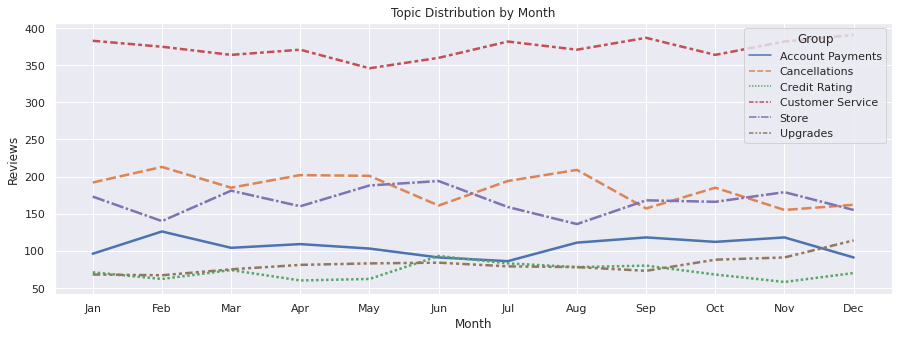

In [93]:
# test the topic plot
plots_topic_by_month(
    data=df_assigned,
    title='Topic Distribution by Month',
    num_groups=6)    

#### 2) Comparing Vodacom and MTN

Two separate plots are created to compare the topic distribution between Vodacom and MTN. Here it would seem that Vodacom receives more general customer service complaints than MTN, while MTN receives more complaints related to their physical store presence. 

From these plots, it becomes evident that the September upward trend in upgrade complaints are from MTN.

As an example of how these insights might be used, looking from the perspective of Vodacom, the following are possible follow up actions:

- Fewer complaints related to stores might indicate Vodacom customers have a better experience when visiting a brick and mortar store than MTN customers. Vodacom can consider using this knowledge to further set themselves apart from competetors by, for example, making further improvements to stores or staff customer service training, and using marketing strategies to promote their stores and entice competitor customers to visit their stores.
- The upward trend in complaints about upgrades in the last few months of the year should be investigated as it might indicate a period where MTN customer typically renew their contracts. If this is indeed this case, this would be an excellent opportunity for the entire customer due for contract renewals to switch to Vodacom.

These examples are just that and do not imply that Vodacom can start pursuing these strategies without further investigation. However, it should be clear how powerful this approach is since the reviews themselves are the source for further investigation. When combined with external information and industry- and marketing knowledge, this could be a goldmine to improve customer service levels and potential business improvements to increase revenue.

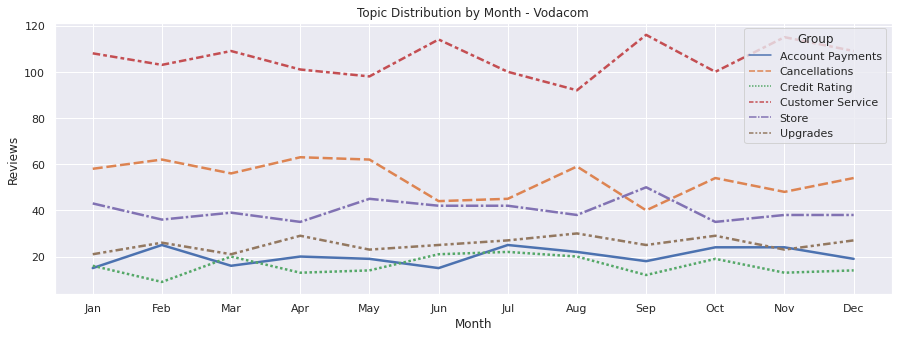

In [94]:
# plot the topics distribution for vodacom
plots_topic_by_month(
    data=df_assigned,
    title='Topic Distribution by Month - Vodacom',
    business='vodacom',
    num_groups=6)   

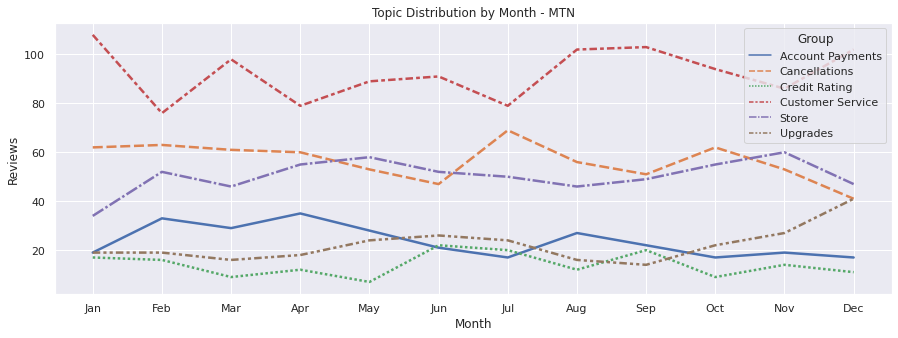

In [95]:
# plot the topics distribution for mtn
plots_topic_by_month(
    data=df_assigned,
    title='Topic Distribution by Month - MTN',
    business='mtn',
    num_groups=6)   

### B. Limitations and Future Work

Although no comparison could be made between positive and negative reviews, the relative ease at which meaningful topics could be derived does seem to indicate that separability between negative reviews is not necessarily lower for all datasets. However, it should be noted that the most prominent topic concerned general customer service complaints. Therefore, further study is required using a dataset with a better balance between positive and negative reviews to draw a more concrete conclusion following the approach used by Kirilenko et al. [2].

The aim of this study was not to do a deep analysis of the data, and future work is needed to gain additional insights from the data, for example, explore creating a second layer topic model to uncover sub-topics present in the general customer service complaints category. 

## Bibliography

- [1]	J. I. Foulds, “Content Analysis of user complaints of the four largest Telecommunications companies in South Africa,” 2020.
- [2]	A. P. Kirilenko, S. O. Stepchenkova, and X. Dai, “Automated topic modeling of tourist reviews: Does the Anna Karenina principle apply?,” Tourism Management, vol. 83, Apr. 2021, doi: 10.1016/j.tourman.2020.104241.
- [3]	Y. T. Leung and F. Khalvati, “Exploring COVID-19 Related Stressors Using Topic Modeling,” Jan. 2022, [Online]. Available: http://arxiv.org/abs/2202.00476
- [4]	J. Tang, Z. Meng, X. Nguyen, Q. Mei, and M. Zhang, “Understanding the Limiting Factors of Topic Modeling via Posterior Contraction Analysis,” in Proceedings of the 31st International Conference on Machine Learning, Feb. 2014, vol. 32, no. 1, pp. 190–198. [Online]. Available: https://proceedings.mlr.press/v32/tang14.html

## Appendix A: Web References

The folling is a list of technical resources that were consulted.

### Topic Modelling

- [Matti Lyra - Evaluating Topic Models](https://www.youtube.com/watch?v=UkmIljRIG_M)
- [Bhargav Srinivasa Desikan - Topic Modelling (and more) with NLP framework Gensim](https://www.youtube.com/watch?v=ZkAFJwi-G98)
- [Gensim - Latent Dirichlet Allocation](https://radimrehurek.com/gensim/models/ldamodel.html)

### Pycaret

- [Topic Modeling on PyCaret](https://towardsdatascience.com/topic-modeling-on-pycaret-2ce0c65ba3ff)
- [Natural Language Processing Tutorial (NLP101) - Level Beginner](https://github.com/pycaret/pycaret/blob/master/tutorials/Natural%20Language%20Processing%20Tutorial%20Level%20Beginner%20-%20NLP101.ipynb)
- [Natural Language Processing Tutorial (NLP102) - Level Intermediate](https://github.com/pycaret/pycaret/blob/master/tutorials/Natural%20Language%20Processing%20Tutorial%20Level%20Intermediate%20-%20NLP102.ipynb)
- [Five common misunderstandings of pycaret](https://developpaper.com/five-common-misunderstandings-of-pycaret/)

### Plots

- [seaborn - Example gallery](https://seaborn.pydata.org/examples/index.html)
- [Creating multiple subplots using plt.subplots](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html)

### Dataset

- [How to balance a dataset in Python](https://towardsdatascience.com/how-to-balance-a-dataset-in-python-36dff9d12704)

### Other

- [Capturing Output With %%capture](https://notebook.community/lifeinoppo/littlefishlet-scode/RES/REF/python_sourcecode/ipython-master/examples/IPython%20Kernel/Capturing%20Output)
- [Side by side Wordclouds in matplotlib](https://stackoverflow.com/questions/34165130/side-by-side-wordclouds-in-matplotlib)
- [BASE64 Image](https://www.base64-image.de/)
- [TableCleaner](https://www.r2h.nl/html-word-excel-table-code-cleaner/index.php)
- [Convert HTML Table to Markdown Table](https://tableconvert.com/html-to-markdown)